In [46]:
from dataclasses import dataclass
from typing import Any, Dict, List, Literal, Optional, Tuple, Union

import einops as E
import torch
from torch import nn

from universeg.nn import CrossConv2d
from universeg.nn import reset_conv2d_parameters
from universeg.nn import Vmap, vmap
from universeg.validation import (Kwargs, as_2tuple, size2t, validate_arguments,
                         validate_arguments_init)

In [47]:
def get_nonlinearity(nonlinearity: Optional[str]) -> nn.Module:
    if nonlinearity is None:
        return nn.Identity()
    if nonlinearity == "Softmax":
        # For Softmax, we need to specify the channel dimension
        return nn.Softmax(dim=1)
    if hasattr(nn, nonlinearity):
        return getattr(nn, nonlinearity)()
    raise ValueError(f"nonlinearity {nonlinearity} not found")

In [48]:
@validate_arguments_init
@dataclass(eq=False, repr=False)
class ConvOp(nn.Sequential):

    in_channels: int
    out_channels: int
    kernel_size: size2t = 3
    nonlinearity: Optional[str] = "LeakyReLU"
    init_distribution: Optional[str] = "kaiming_normal"
    init_bias: Union[None, float, int] = 0.0

    def __post_init__(self):
        super().__init__()
        self.conv = nn.Conv2d(
            self.in_channels,
            self.out_channels,
            kernel_size=self.kernel_size,
            padding=self.kernel_size // 2,
            padding_mode="zeros",
            bias=True,
        )

        if self.nonlinearity is not None:
            self.nonlin = get_nonlinearity(self.nonlinearity)

        reset_conv2d_parameters(
            self, self.init_distribution, self.init_bias, self.nonlinearity
        )

In [49]:
@validate_arguments_init
@dataclass(eq=False, repr=False)
class CrossOp(nn.Module):

    in_channels: size2t
    out_channels: int
    kernel_size: size2t = 3
    nonlinearity: Optional[str] = "LeakyReLU"
    init_distribution: Optional[str] = "kaiming_normal"
    init_bias: Union[None, float, int] = 0.0

    def __post_init__(self):
        super().__init__()

        self.cross_conv = CrossConv2d(
            in_channels=as_2tuple(self.in_channels),
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            padding=self.kernel_size // 2,
        )

        if self.nonlinearity is not None:
            self.nonlin = get_nonlinearity(self.nonlinearity)

        reset_conv2d_parameters(
            self, self.init_distribution, self.init_bias, self.nonlinearity
        )

    def forward(self, target, support):
        interaction = self.cross_conv(target, support).squeeze(dim=1)

        if self.nonlinearity is not None:
            interaction = vmap(self.nonlin, interaction)

        new_target = interaction.mean(dim=1, keepdims=True)

        return new_target, interaction

In [50]:
@validate_arguments_init
@dataclass(eq=False, repr=False)
class CrossBlock(nn.Module):

    in_channels: size2t
    cross_features: int
    conv_features: Optional[int] = None
    cross_kws: Optional[Dict[str, Any]] = None
    conv_kws: Optional[Dict[str, Any]] = None

    def __post_init__(self):
        super().__init__()

        conv_features = self.conv_features or self.cross_features
        cross_kws = self.cross_kws or {}
        conv_kws = self.conv_kws or {}

        self.cross = CrossOp(self.in_channels, self.cross_features, **cross_kws)
        self.target = Vmap(ConvOp(self.cross_features, conv_features, **conv_kws))
        self.support = Vmap(ConvOp(self.cross_features, conv_features, **conv_kws))

    def forward(self, target, support):
        target, support = self.cross(target, support)
        target = self.target(target)
        support = self.support(support)
        return target, support


In [69]:
@validate_arguments_init
@dataclass(eq=False, repr=False)
class UniverSeg(nn.Module):

    encoder_blocks: List[size2t]
    decoder_blocks: Optional[List[size2t]] = None

    def __post_init__(self):
        super().__init__()

        self.downsample = nn.MaxPool2d(2, 2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        self.enc_blocks = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()

        
        encoder_blocks = list(map(as_2tuple, self.encoder_blocks))
        # print(as_2tuple)
        print(encoder_blocks) #[(64, 64), (64, 64), (64, 64), (64, 64)]
        decoder_blocks = self.decoder_blocks or encoder_blocks[-2::-1]
        decoder_blocks = list(map(as_2tuple, decoder_blocks))
        
        block_kws = dict(cross_kws=dict(nonlinearity=None))

        in_ch = (1, 2)
        out_channels = 1
        out_activation = None

        # Encoder
        skip_outputs = []
        for (cross_ch, conv_ch) in encoder_blocks:
            block = CrossBlock(in_ch, cross_ch, conv_ch, **block_kws)
            in_ch = conv_ch
            self.enc_blocks.append(block)
            skip_outputs.append(in_ch)

        # Decoder
        skip_chs = skip_outputs[-2::-1]
        for (cross_ch, conv_ch), skip_ch in zip(decoder_blocks, skip_chs):
            block = CrossBlock(in_ch + skip_ch, cross_ch, conv_ch, **block_kws)
            in_ch = conv_ch
            self.dec_blocks.append(block)

        self.out_conv = ConvOp(
            in_ch, out_channels, kernel_size=1, nonlinearity=out_activation,
        )

    def forward(self, target_image, support_images, support_labels):
        # Chuyển đổi target_image thành dạng phù hợp
        target = E.rearrange(target_image, "B 1 H W -> B 1 1 H W")

        # Nối support_images và support_labels để tạo tensor đầu vào
        support = torch.cat([support_images, support_labels], dim=2)

        # List để lưu trữ đầu ra của mỗi lớp chuyển tiếp
        pass_through = []

        # Quá trình mã hóa
        for i, encoder_block in enumerate(self.enc_blocks):
            target, support = encoder_block(target, support)
            if i == len(self.encoder_blocks) - 1: #Lớp mã hóa cuối
                break
            pass_through.append((target, support))
            target = vmap(self.downsample, target)
            support = vmap(self.downsample, support)

        # Quá trình giải mã
        for decoder_block in self.dec_blocks:
            target_skip, support_skip = pass_through.pop()
            target = torch.cat([vmap(self.upsample, target), target_skip], dim=2)
            support = torch.cat([vmap(self.upsample, support), support_skip], dim=2)
            target, support = decoder_block(target, support)

        target = E.rearrange(target, "B 1 C H W -> B C H W")
        target = self.out_conv(target)

        return target


In [52]:
@validate_arguments
def universeg(version: Literal["v1"] = "v1", pretrained: bool = False) -> nn.Module:
    weights = {
        "v1": "https://github.com/JJGO/UniverSeg/releases/download/weights/universeg_v1_nf64_ss64_STA.pt"
    }

    if version == "v1":
        model = UniverSeg(encoder_blocks=[64, 64, 64, 64])

    if pretrained:
        state_dict = torch.hub.load_state_dict_from_url(weights[version])
        model.load_state_dict(state_dict)

    return model


### Cách hoạt động Encoder:

In [53]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

In [54]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Cấu trúc 1 layer Encoder:

In [70]:
# Khởi tạo mô hình UniverSeg
model = UniverSeg(encoder_blocks=[64])


print(model.enc_blocks)

[(64, 64)]
ModuleList(
  (0): CrossBlock(
    (cross): CrossOp(
      (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (target): Vmap(
      (vmapped): ConvOp(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (nonlin): LeakyReLU(negative_slope=0.01)
      )
    )
    (support): Vmap(
      (vmapped): ConvOp(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (nonlin): LeakyReLU(negative_slope=0.01)
      )
    )
  )
)


### Cấu trúc model với lớp Encoder như trên:
- target = E.rearrange(target_image, "B 1 H W -> B 1 1 H W")
    - Đổi chiều từ (B,1,H,W) thành (B,1,1,H,W)
- support = torch.cat([support_images, support_labels], dim=2)
    - Nối support_images và support_labels để tạo tensor đầu vào
    - (48,1,1,128,128) và (48,1,1,128,128) : Nối theo chiều kênh


- List để lưu trữ đầu ra của mỗi lớp chuyển tiếp: pass_through = []

- Phần mã hóa:
```
for i, encoder_block in enumerate(self.enc_blocks):
    target, support = encoder_block(target, support)
    if i == len(self.encoder_blocks) - 1: #Lớp mã hóa cuối
        break
    pass_through.append((target, support)) #Lưu đầu ra
    target = vmap(self.downsample, target) #Áp dụng self.downsample cho target
    support = vmap(self.downsample, support)
```

- Phần giải mã của quá trình mã hóa trên:
```
for decoder_block in self.dec_blocks:
    target_skip, support_skip = pass_through.pop()
    target = torch.cat([vmap(self.upsample, target), target_skip], dim=2)
    support = torch.cat([vmap(self.upsample, support), support_skip], dim=2)
    target, support = decoder_block(target, support)
```
target = E.rearrange(target, "B 1 C H W -> B C H W")
target = self.out_conv(target)

### Tìm hiểu số chiều của mô hình

```
ModuleList(
  (0): CrossBlock(
    (cross): CrossOp(
      (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (target): Vmap(
      (vmapped): ConvOp(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (nonlin): LeakyReLU(negative_slope=0.01)
      )
    )
    (support): Vmap(
      (vmapped): ConvOp(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (nonlin): LeakyReLU(negative_slope=0.01)
      )
    )
  )
)
```

- (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - Tham số (in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - Đầu vào là tensor có 5 chiều target và support
    - Target được đổi từ (B,1,H,W) thành (B,1,1,H,W)
    - Support phải có 5 chiều VD: x = torch.randn(2, 3, 2, 32, 32)  # B=2, Sx=3, Cx=2, H=32, W=32
    - in_channels = 3 ở đây là 2+1. Trong code in_channels = (1,2). Nghĩa là số kênh nhận vào là 1 hoặc 2.
    - out_channels = 64


In [76]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 1

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

# Khởi tạo mô hình UniverSeg
model = UniverSeg(encoder_blocks=[64])

idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.reshape(1,1,128,128), label.reshape(1,1,128,128)
image, label = image.to(device), label.to(device)

support_images, support_labels = support_images.reshape(n_support,1,1,128,128), support_labels.reshape(n_support,1,1,128,128)
# model.forward(image, support_images, support_labels)
# print(support_images.shape)

# Chạy quá trình chuyển tiếp
output = model(image, support_images, support_labels)


[(64, 64)]


In [84]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [80]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [81]:
# run inference and compute losses for one test image
@torch.no_grad() #Không cập nhật mô hình
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits        

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

In [85]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


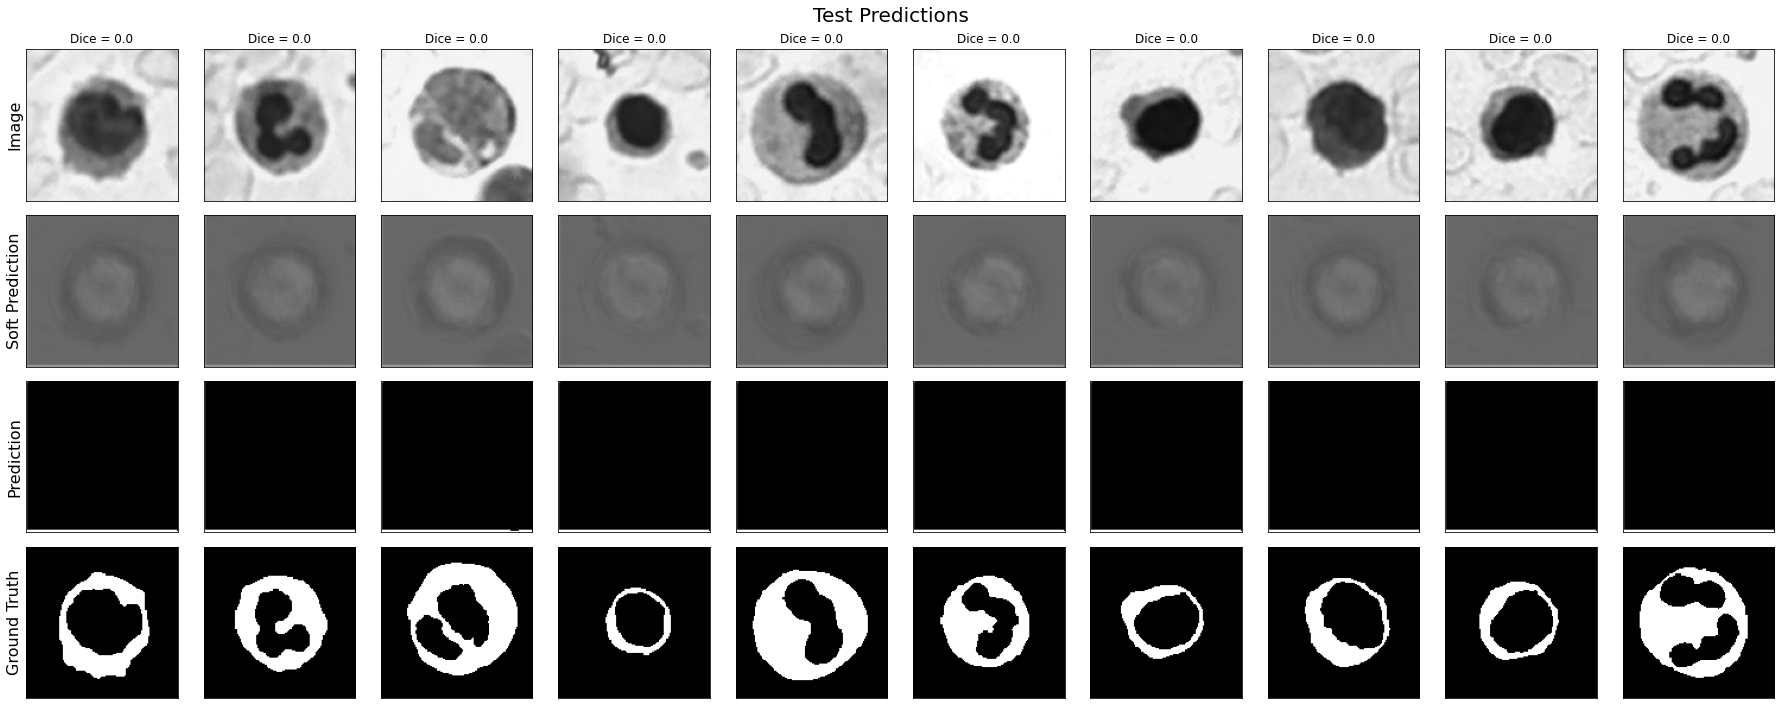

In [86]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)
    
# visualize the results, along with their scores
scores = results.pop('score')    
visualize_tensors(results, 
                  col_names=[f'Dice = {100*s:.1f}' for s in scores], 
                  title='Test Predictions', 
                  col_wrap=n_predictions)